In [2]:
import torch
import os
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from training_data import CombinedData
from PIL import Image
from matplotlib import pyplot as plt

data_train = CombinedData('HASY')
data_test = CombinedData('HASY', train=False)

print("Train data length: {0}".format(len(data_train.data)))
print("Test data length: {0}".format(len(data_test.data)))
print("Img Shape: {0}".format(data_train.data[0].shape))
print("Number of Labels: {0}".format(data_train.no_labels))

100%|██████████| 10000/10000 [00:00<00:00, 351540.83it/s]


Train data length: 65878
Test data length: 10832
Img Shape: torch.Size([1, 32, 32])
Number of Labels: 15


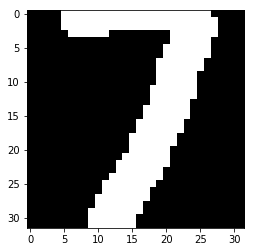

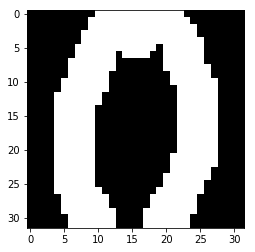

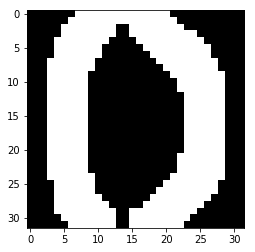

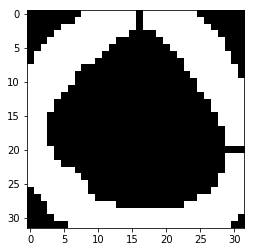

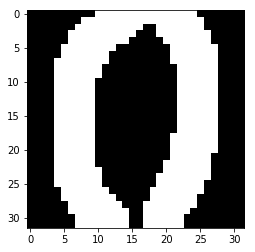

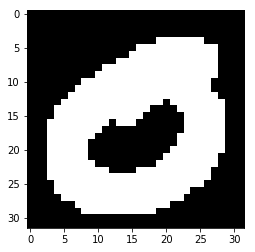

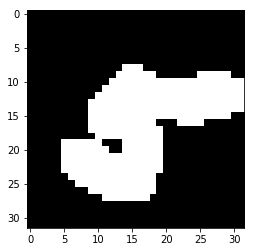

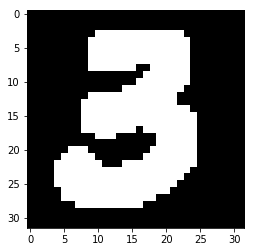

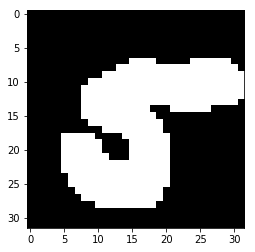

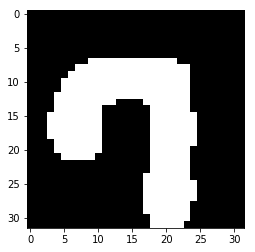

In [3]:
from torchvision import transforms
for i in range(5):
    test_img = transforms.ToPILImage()(data_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
for i in range(7000, 7005):
    test_img = transforms.ToPILImage()(data_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()

In [4]:
# Train with a pretrained model from PyTorch
from torchvision import models
from torch.nn import Conv2d

pretrained = False
torch_model = models.alexnet(num_classes=15)
torch_model.features[0] = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
if pretrained:
    torch_model.load_state_dict(torch.load('pretrained-model-01.ckpt'))
epochs = 10
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001, betas=(0.95, 0.95), weight_decay=0)
criterion = nn.CrossEntropyLoss()

def calc_accuracy(model):
    accuracies = []
    for idx, [x_test, y_test] in enumerate(tqdm(test_loader)):
        test_pred = model(x_test)
        accuracy = 100 * torch.mean((torch.argmax(test_pred, dim=1) == y_test).float())
        accuracies.append(accuracy)
    return np.mean(accuracies)  

train_loader = DataLoader(data_train, batch_size=16, shuffle=True)
test_loader = DataLoader(data_test, batch_size=16, shuffle=False)

print(torch_model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3):

In [5]:
for epoch in range(epochs):
    print("Epoch {0}".format(epoch))
    acc = calc_accuracy(torch_model)
    print("Accuracy: {0}".format(acc))
    if acc > 80:
        torch.save(torch_model.state_dict(), 'combined-model-{0}.ckpt'.format(acc))
    for step, [x_train, y_train] in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        train_pred = torch_model(x_train)
        loss = criterion(train_pred, y_train)
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print('Loss: {}'.format(loss))
acc = calc_accuracy(torch_model)
print("Accuracy: {0}".format(acc))
torch.save(torch_model.state_dict(), 'combined-model-v3.ckpt')

  0%|          | 2/677 [00:00<00:39, 17.21it/s]

Epoch 0


  0%|          | 0/4118 [00:00<?, ?it/s]

Accuracy: 7.782496452331543


  0%|          | 1/4118 [00:00<1:00:12,  1.14it/s]

Loss: 2.7008891105651855


  2%|▏         | 101/4118 [01:15<50:02,  1.34it/s]

Loss: 1.9790254831314087


  5%|▍         | 201/4118 [02:29<49:24,  1.32it/s]

Loss: 1.75913405418396


  7%|▋         | 301/4118 [03:49<50:56,  1.25it/s]  

Loss: 1.4406003952026367


 10%|▉         | 401/4118 [04:54<37:43,  1.64it/s]  

Loss: 0.9924538135528564


 12%|█▏        | 501/4118 [05:48<28:49,  2.09it/s]

Loss: 1.1706080436706543


 15%|█▍        | 601/4118 [06:36<26:34,  2.21it/s]

Loss: 0.9471995234489441


 17%|█▋        | 701/4118 [07:25<28:26,  2.00it/s]

Loss: 0.7972868084907532


 19%|█▉        | 801/4118 [08:20<29:01,  1.90it/s]

Loss: 0.2765321731567383


 22%|██▏       | 901/4118 [09:23<31:58,  1.68it/s]

Loss: 0.2392367571592331


 24%|██▍       | 1001/4118 [10:28<34:51,  1.49it/s]

Loss: 0.41073083877563477


 27%|██▋       | 1101/4118 [11:36<34:06,  1.47it/s]

Loss: 0.31951677799224854


 29%|██▉       | 1201/4118 [12:51<40:06,  1.21it/s]

Loss: 0.4666781723499298


 32%|███▏      | 1301/4118 [14:35<1:06:38,  1.42s/it]

Loss: 0.1976892203092575


 34%|███▍      | 1401/4118 [17:43<1:39:21,  2.19s/it]

Loss: 0.31951361894607544


 36%|███▋      | 1501/4118 [21:37<1:45:17,  2.41s/it]

Loss: 0.38629329204559326


 39%|███▉      | 1601/4118 [25:33<1:34:57,  2.26s/it]

Loss: 0.0904008150100708


 41%|████▏     | 1701/4118 [29:05<1:09:48,  1.73s/it]

Loss: 1.0888913869857788


 44%|████▎     | 1801/4118 [31:51<1:05:20,  1.69s/it]

Loss: 1.039750576019287


 46%|████▌     | 1901/4118 [34:37<1:03:05,  1.71s/it]

Loss: 0.11039067804813385


 49%|████▊     | 2001/4118 [37:26<59:14,  1.68s/it]  

Loss: 0.6996229887008667


 51%|█████     | 2101/4118 [40:16<58:47,  1.75s/it]  

Loss: 0.13081881403923035


 53%|█████▎    | 2201/4118 [43:09<54:12,  1.70s/it]

Loss: 0.6221536993980408


 56%|█████▌    | 2301/4118 [46:03<53:19,  1.76s/it]

Loss: 0.5483719110488892


 58%|█████▊    | 2401/4118 [48:52<48:25,  1.69s/it]

Loss: 0.280425488948822


 61%|██████    | 2501/4118 [51:46<47:52,  1.78s/it]

Loss: 0.09299373626708984


 63%|██████▎   | 2601/4118 [54:40<44:56,  1.78s/it]

Loss: 0.8968205451965332


 66%|██████▌   | 2701/4118 [57:38<41:41,  1.77s/it]

Loss: 0.21344801783561707


 68%|██████▊   | 2801/4118 [1:00:32<37:40,  1.72s/it]

Loss: 0.3179194927215576


 70%|███████   | 2901/4118 [1:03:26<34:43,  1.71s/it]

Loss: 0.3346008062362671


 73%|███████▎  | 3001/4118 [1:06:29<37:08,  1.99s/it]

Loss: 0.5059454441070557


 75%|███████▌  | 3101/4118 [1:09:45<32:47,  1.93s/it]

Loss: 0.807022213935852


 78%|███████▊  | 3201/4118 [1:13:04<29:40,  1.94s/it]

Loss: 0.4397236704826355


 80%|████████  | 3301/4118 [1:16:18<26:23,  1.94s/it]

Loss: 0.06370764970779419


 83%|████████▎ | 3401/4118 [1:19:35<23:48,  1.99s/it]

Loss: 0.30852681398391724


 85%|████████▌ | 3501/4118 [1:22:51<17:47,  1.73s/it]

Loss: 0.31425759196281433


 87%|████████▋ | 3601/4118 [1:25:43<15:24,  1.79s/it]

Loss: 0.6578658819198608


 90%|████████▉ | 3701/4118 [1:28:39<11:55,  1.71s/it]

Loss: 0.4771963357925415


 92%|█████████▏| 3801/4118 [1:31:35<09:10,  1.74s/it]

Loss: 0.23802033066749573


 95%|█████████▍| 3901/4118 [1:34:30<06:14,  1.73s/it]

Loss: 0.19922280311584473


 97%|█████████▋| 4001/4118 [1:37:26<03:22,  1.73s/it]

Loss: 0.5133962631225586


100%|█████████▉| 4101/4118 [1:40:21<00:29,  1.72s/it]

Loss: 0.19778750836849213


  0%|          | 3/677 [00:00<00:29, 22.52it/s]

Epoch 1


  0%|          | 0/4118 [00:00<?, ?it/s]

Accuracy: 92.78987884521484


  0%|          | 1/4118 [00:01<2:00:36,  1.76s/it]

Loss: 0.24072802066802979


  2%|▏         | 101/4118 [02:58<1:55:59,  1.73s/it]

Loss: 0.2435332089662552


  5%|▍         | 201/4118 [05:56<1:59:10,  1.83s/it]

Loss: 0.3170923888683319


  7%|▋         | 301/4118 [08:54<1:51:30,  1.75s/it]

Loss: 1.4849684238433838


 10%|▉         | 401/4118 [11:53<1:52:30,  1.82s/it]

Loss: 0.06345020234584808


 12%|█▏        | 501/4118 [14:51<1:45:27,  1.75s/it]

Loss: 0.2863520383834839


 15%|█▍        | 601/4118 [17:48<1:44:29,  1.78s/it]

Loss: 0.055253446102142334


 17%|█▋        | 701/4118 [20:44<1:39:33,  1.75s/it]

Loss: 0.011569082736968994


 19%|█▉        | 801/4118 [23:41<1:36:26,  1.74s/it]

Loss: 0.1903534233570099


 22%|██▏       | 901/4118 [26:38<1:33:34,  1.75s/it]

Loss: 0.9734673500061035


 24%|██▍       | 1001/4118 [29:37<1:31:49,  1.77s/it]

Loss: 0.4849682152271271


 27%|██▋       | 1101/4118 [32:33<1:28:44,  1.76s/it]

Loss: 0.018954545259475708


 29%|██▉       | 1201/4118 [35:32<1:29:15,  1.84s/it]

Loss: 0.019732624292373657


 32%|███▏      | 1301/4118 [38:32<1:23:17,  1.77s/it]

Loss: 0.1445172131061554


 34%|███▍      | 1401/4118 [41:32<1:23:02,  1.83s/it]

Loss: 0.3648343086242676


 36%|███▋      | 1501/4118 [44:29<1:16:30,  1.75s/it]

Loss: 0.3338932394981384


 39%|███▉      | 1601/4118 [47:25<1:13:25,  1.75s/it]

Loss: 0.4461634159088135


 41%|████▏     | 1701/4118 [50:26<1:13:59,  1.84s/it]

Loss: 0.9700947999954224


 44%|████▎     | 1801/4118 [53:25<1:09:50,  1.81s/it]

Loss: 0.6762890815734863


 46%|████▌     | 1901/4118 [56:22<1:04:50,  1.75s/it]

Loss: 0.2790589928627014


 49%|████▊     | 2001/4118 [59:21<1:04:50,  1.84s/it]

Loss: 0.3462241590023041


 51%|█████     | 2101/4118 [1:02:22<59:14,  1.76s/it]  

Loss: 0.13059043884277344


 53%|█████▎    | 2201/4118 [1:05:20<56:19,  1.76s/it]  

Loss: 1.007495403289795


 56%|█████▌    | 2301/4118 [1:08:17<53:04,  1.75s/it]

Loss: 0.04408865422010422


 58%|█████▊    | 2401/4118 [1:11:16<50:36,  1.77s/it]

Loss: 0.15693910419940948


 61%|██████    | 2501/4118 [1:14:16<49:36,  1.84s/it]

Loss: 0.31237199902534485


 63%|██████▎   | 2601/4118 [1:17:12<44:36,  1.76s/it]

Loss: 0.3854026794433594


 66%|██████▌   | 2701/4118 [1:20:11<41:37,  1.76s/it]

Loss: 0.18764543533325195


 68%|██████▊   | 2801/4118 [1:23:12<39:08,  1.78s/it]

Loss: 0.7686087489128113


 70%|███████   | 2901/4118 [1:26:11<35:53,  1.77s/it]

Loss: 1.198436975479126


 73%|███████▎  | 3001/4118 [1:29:11<33:19,  1.79s/it]

Loss: 0.189264714717865


 75%|███████▌  | 3101/4118 [1:32:10<30:01,  1.77s/it]

Loss: 0.06184515357017517


 78%|███████▊  | 3201/4118 [1:35:10<27:37,  1.81s/it]

Loss: 0.5052852630615234


 80%|████████  | 3301/4118 [1:38:11<24:45,  1.82s/it]

Loss: 0.05956672132015228


 83%|████████▎ | 3401/4118 [1:41:14<21:20,  1.79s/it]

Loss: 0.3196181356906891


 85%|████████▌ | 3501/4118 [1:44:13<18:31,  1.80s/it]

Loss: 0.24160820245742798


 87%|████████▋ | 3601/4118 [1:47:15<15:55,  1.85s/it]

Loss: 0.23763933777809143


 90%|████████▉ | 3701/4118 [1:50:17<12:29,  1.80s/it]

Loss: 0.38624319434165955


 92%|█████████▏| 3801/4118 [1:53:17<09:40,  1.83s/it]

Loss: 0.0718303918838501


 95%|█████████▍| 3901/4118 [1:56:22<06:48,  1.88s/it]

Loss: 0.14511768519878387


 97%|█████████▋| 4001/4118 [1:59:43<03:58,  2.04s/it]

Loss: 0.2710428535938263


100%|█████████▉| 4101/4118 [2:03:11<00:35,  2.12s/it]

Loss: 0.04362943768501282


  0%|          | 2/677 [00:00<00:39, 17.17it/s]

Epoch 2


  0%|          | 0/4118 [00:00<?, ?it/s]

Accuracy: 92.31905364990234


  0%|          | 1/4118 [00:02<2:24:01,  2.10s/it]

Loss: 0.06647299230098724


  2%|▏         | 101/4118 [03:28<2:20:59,  2.11s/it]

Loss: 0.3802926242351532


  5%|▍         | 201/4118 [06:32<1:56:14,  1.78s/it]

Loss: 2.4939281940460205


  7%|▋         | 301/4118 [09:33<1:58:36,  1.86s/it]

Loss: 0.5576580166816711


 10%|▉         | 401/4118 [12:34<1:50:52,  1.79s/it]

Loss: 0.021584242582321167


 12%|█▏        | 501/4118 [15:36<1:48:24,  1.80s/it]

Loss: 0.27974969148635864


 15%|█▍        | 601/4118 [18:39<1:49:38,  1.87s/it]

Loss: 0.0006539821624755859


 17%|█▋        | 701/4118 [21:40<1:45:04,  1.85s/it]

Loss: 0.30944427847862244


 19%|█▉        | 801/4118 [24:43<1:38:58,  1.79s/it]

Loss: 0.30722323060035706


 22%|██▏       | 901/4118 [27:49<1:50:59,  2.07s/it]

Loss: 0.22076308727264404


 24%|██▍       | 1001/4118 [31:15<1:46:25,  2.05s/it]

Loss: 0.02165520191192627


 27%|██▋       | 1101/4118 [34:39<1:39:51,  1.99s/it]

Loss: 3.277696132659912


 29%|██▉       | 1201/4118 [37:55<1:26:13,  1.77s/it]

Loss: 0.23125000298023224


 32%|███▏      | 1301/4118 [40:55<1:25:44,  1.83s/it]

Loss: 1.16519296169281


 34%|███▍      | 1401/4118 [43:52<1:19:57,  1.77s/it]

Loss: 2.3444485664367676


 36%|███▋      | 1501/4118 [46:52<1:19:36,  1.83s/it]

Loss: 0.3435242176055908


 39%|███▉      | 1601/4118 [50:05<1:26:02,  2.05s/it]

Loss: 0.6171157956123352


 41%|████▏     | 1701/4118 [53:33<1:20:39,  2.00s/it]

Loss: 0.4417373836040497


 44%|████▎     | 1801/4118 [56:57<1:18:04,  2.02s/it]

Loss: 0.7136837840080261


 46%|████▌     | 1901/4118 [1:00:06<1:05:46,  1.78s/it]

Loss: 2.2592947483062744


 49%|████▊     | 2001/4118 [1:03:05<1:02:43,  1.78s/it]

Loss: 0.2731786072254181


 51%|█████     | 2101/4118 [1:06:04<59:38,  1.77s/it]  

Loss: 0.05849234759807587


 53%|█████▎    | 2201/4118 [1:09:03<56:25,  1.77s/it]  

Loss: 0.24095609784126282


 56%|█████▌    | 2301/4118 [1:12:07<57:08,  1.89s/it]

Loss: 0.45075997710227966


 58%|█████▊    | 2401/4118 [1:15:11<52:08,  1.82s/it]

Loss: 0.08349135518074036


 61%|██████    | 2501/4118 [1:18:14<49:15,  1.83s/it]

Loss: 0.28630638122558594


 63%|██████▎   | 2601/4118 [1:21:13<45:01,  1.78s/it]

Loss: 0.48970827460289


 66%|██████▌   | 2701/4118 [1:24:17<42:38,  1.81s/it]

Loss: 1.6607871055603027


 68%|██████▊   | 2801/4118 [1:27:19<40:58,  1.87s/it]

Loss: 0.041111767292022705


 70%|███████   | 2901/4118 [1:30:22<36:12,  1.79s/it]

Loss: 3.7010834217071533


 73%|███████▎  | 3001/4118 [1:33:23<33:02,  1.78s/it]

Loss: 0.3348398208618164


 75%|███████▌  | 3101/4118 [1:36:25<30:28,  1.80s/it]

Loss: 0.25821053981781006


 78%|███████▊  | 3201/4118 [1:39:26<27:54,  1.83s/it]

Loss: 0.5246033072471619


 80%|████████  | 3301/4118 [1:42:29<24:33,  1.80s/it]

Loss: 0.3407391309738159


 83%|████████▎ | 3401/4118 [1:45:29<21:25,  1.79s/it]

Loss: 0.20905569195747375


 85%|████████▌ | 3501/4118 [1:48:33<19:13,  1.87s/it]

Loss: 0.38459640741348267


 87%|████████▋ | 3601/4118 [1:51:38<15:29,  1.80s/it]

Loss: 0.2247007191181183


 90%|████████▉ | 3701/4118 [1:54:43<12:38,  1.82s/it]

Loss: 0.15717923641204834


 92%|█████████▏| 3801/4118 [1:57:45<09:24,  1.78s/it]

Loss: 0.03611291944980621


 95%|█████████▍| 3901/4118 [2:00:45<06:48,  1.88s/it]

Loss: 0.26676511764526367


 97%|█████████▋| 4001/4118 [2:03:44<03:32,  1.82s/it]

Loss: 0.47542545199394226


100%|█████████▉| 4101/4118 [2:06:45<00:30,  1.80s/it]

Loss: 0.6856477856636047


  0%|          | 3/677 [00:00<00:26, 25.68it/s]

Epoch 3


  0%|          | 0/4118 [00:00<?, ?it/s]

Accuracy: 88.99556732177734


  0%|          | 1/4118 [00:01<2:04:35,  1.82s/it]

Loss: 0.6992366313934326


  2%|▏         | 101/4118 [03:02<2:01:28,  1.81s/it]

Loss: 0.2641386389732361


  5%|▍         | 201/4118 [06:04<1:57:42,  1.80s/it]

Loss: 0.4840027093887329


  7%|▋         | 301/4118 [09:04<1:54:47,  1.80s/it]

Loss: 0.2363533079624176


 10%|▉         | 401/4118 [12:18<2:08:23,  2.07s/it]

Loss: 0.4681691527366638


 12%|█▏        | 501/4118 [15:42<2:02:42,  2.04s/it]

Loss: 0.34619688987731934


 15%|█▍        | 601/4118 [19:07<1:58:47,  2.03s/it]

Loss: 0.21332813799381256


 17%|█▋        | 701/4118 [22:37<2:00:41,  2.12s/it]

Loss: 0.1279592663049698


 19%|█▉        | 801/4118 [25:46<1:42:11,  1.85s/it]

Loss: 0.36293086409568787


 22%|██▏       | 901/4118 [28:48<1:40:34,  1.88s/it]

Loss: 1.2708016633987427


 24%|██▍       | 1001/4118 [31:52<1:35:51,  1.85s/it]

Loss: 0.07420958578586578


 27%|██▋       | 1101/4118 [34:54<1:30:26,  1.80s/it]

Loss: 0.01634007692337036


 29%|██▉       | 1201/4118 [38:16<1:38:03,  2.02s/it]

Loss: 0.3177783489227295


 32%|███▏      | 1301/4118 [41:44<1:44:28,  2.23s/it]

Loss: 1.8980485200881958


 34%|███▍      | 1401/4118 [45:10<1:35:26,  2.11s/it]

Loss: 0.43304312229156494


 36%|███▋      | 1501/4118 [48:37<1:30:25,  2.07s/it]

Loss: 0.5164086818695068


 39%|███▉      | 1601/4118 [52:01<1:25:42,  2.04s/it]

Loss: 0.6720899343490601


 41%|████▏     | 1701/4118 [55:27<1:26:52,  2.16s/it]

Loss: 0.3172774910926819


 44%|████▎     | 1801/4118 [58:52<1:16:40,  1.99s/it]

Loss: 0.8643480539321899


 46%|████▌     | 1901/4118 [1:02:06<1:08:55,  1.87s/it]

Loss: 0.2423655241727829


 49%|████▊     | 2001/4118 [1:05:12<1:05:49,  1.87s/it]

Loss: 0.16783404350280762


 51%|█████     | 2101/4118 [1:08:38<1:07:21,  2.00s/it]

Loss: 0.9092225432395935


 53%|█████▎    | 2201/4118 [1:12:00<1:03:25,  1.98s/it]

Loss: 0.33259230852127075


 56%|█████▌    | 2301/4118 [1:15:25<1:03:51,  2.11s/it]

Loss: 0.16835875809192657


 58%|█████▊    | 2401/4118 [1:18:50<58:35,  2.05s/it]  

Loss: 0.6574110984802246


 61%|██████    | 2501/4118 [1:22:12<54:39,  2.03s/it]

Loss: 0.45043349266052246


 63%|██████▎   | 2601/4118 [1:25:37<51:09,  2.02s/it]

Loss: 0.1753585934638977


 66%|██████▌   | 2701/4118 [1:29:04<49:55,  2.11s/it]

Loss: 0.19867663085460663


 68%|██████▊   | 2801/4118 [1:32:31<44:35,  2.03s/it]

Loss: 0.19128961861133575


 70%|███████   | 2901/4118 [1:35:42<36:25,  1.80s/it]

Loss: 0.16933053731918335


 73%|███████▎  | 3001/4118 [1:38:45<35:10,  1.89s/it]

Loss: 0.9966618418693542


 75%|███████▌  | 3101/4118 [1:41:47<30:59,  1.83s/it]

Loss: 0.05837640166282654


 78%|███████▊  | 3201/4118 [1:44:51<28:15,  1.85s/it]

Loss: 0.5603033304214478


 80%|████████  | 3301/4118 [1:47:52<24:34,  1.81s/it]

Loss: 0.742099404335022


 83%|████████▎ | 3401/4118 [1:50:53<21:24,  1.79s/it]

Loss: 0.8968327045440674


 85%|████████▌ | 3501/4118 [1:53:53<18:29,  1.80s/it]

Loss: 0.1899232119321823


 87%|████████▋ | 3601/4118 [1:57:10<17:33,  2.04s/it]

Loss: 0.07535794377326965


 90%|████████▉ | 3701/4118 [2:00:33<14:03,  2.02s/it]

Loss: 0.5271108150482178


 92%|█████████▏| 3801/4118 [2:04:00<10:37,  2.01s/it]

Loss: 0.4660729765892029


 95%|█████████▍| 3901/4118 [2:07:25<07:35,  2.10s/it]

Loss: 0.4622974395751953


 97%|█████████▋| 4001/4118 [2:10:51<04:07,  2.12s/it]

Loss: 0.029014527797698975


100%|█████████▉| 4101/4118 [2:14:15<00:35,  2.06s/it]

Loss: 0.32331860065460205


  0%|          | 1/677 [00:00<01:13,  9.23it/s]

Epoch 4


  0%|          | 0/4118 [00:00<?, ?it/s]

Accuracy: 85.85671997070312


  0%|          | 1/4118 [00:02<2:17:34,  2.00s/it]

Loss: 0.7785356640815735


  2%|▏         | 101/4118 [03:26<2:16:55,  2.05s/it]

Loss: 0.16071173548698425


  5%|▍         | 201/4118 [06:50<2:13:39,  2.05s/it]

Loss: 0.0031927525997161865


  7%|▋         | 301/4118 [10:15<2:11:02,  2.06s/it]

Loss: 0.130490243434906


 10%|▉         | 401/4118 [13:41<2:05:48,  2.03s/it]

Loss: 0.41986212134361267


 12%|█▏        | 501/4118 [16:57<1:48:59,  1.81s/it]

Loss: 0.0264853835105896


 15%|█▍        | 601/4118 [20:03<1:51:34,  1.90s/it]

Loss: 0.06801760196685791


 17%|█▋        | 701/4118 [23:08<1:46:30,  1.87s/it]

Loss: 0.23208296298980713


 19%|█▉        | 801/4118 [26:25<1:55:20,  2.09s/it]

Loss: 0.4942357540130615


 22%|██▏       | 901/4118 [29:53<1:52:32,  2.10s/it]

Loss: 3.311603546142578


 24%|██▍       | 1001/4118 [33:19<1:47:47,  2.08s/it]

Loss: 0.28924399614334106


 27%|██▋       | 1101/4118 [36:45<1:46:00,  2.11s/it]

Loss: 0.3989076018333435


 29%|██▉       | 1201/4118 [40:14<1:40:13,  2.06s/it]

Loss: 0.6146026253700256


 32%|███▏      | 1301/4118 [43:43<1:39:43,  2.12s/it]

Loss: 0.8852386474609375


 34%|███▍      | 1401/4118 [47:10<1:33:41,  2.07s/it]

Loss: 1.522412896156311


 36%|███▋      | 1501/4118 [50:36<1:27:28,  2.01s/it]

Loss: 0.679894208908081


 39%|███▉      | 1601/4118 [54:02<1:25:00,  2.03s/it]

Loss: 1.067153811454773


 41%|████▏     | 1701/4118 [57:28<1:22:20,  2.04s/it]

Loss: 0.39178773760795593


 44%|████▎     | 1801/4118 [1:00:54<1:21:38,  2.11s/it]

Loss: 0.11310925334692001


 46%|████▌     | 1901/4118 [1:04:21<1:15:17,  2.04s/it]

Loss: 0.08817580342292786


 49%|████▊     | 2001/4118 [1:07:50<1:15:05,  2.13s/it]

Loss: 6.567444801330566


 51%|█████     | 2101/4118 [1:11:13<1:01:30,  1.83s/it]

Loss: 0.3355816602706909


 53%|█████▎    | 2201/4118 [1:14:17<1:04:47,  2.03s/it]

Loss: 0.4073696732521057


 56%|█████▌    | 2301/4118 [1:17:42<1:02:51,  2.08s/it]

Loss: 0.019444674253463745


 58%|█████▊    | 2401/4118 [1:21:09<59:02,  2.06s/it]  

Loss: 0.31071051955223083


 61%|██████    | 2501/4118 [1:24:36<56:12,  2.09s/it]

Loss: 0.7901403903961182


 63%|██████▎   | 2601/4118 [1:27:51<48:21,  1.91s/it]

Loss: 0.522392213344574


 66%|██████▌   | 2701/4118 [1:30:58<47:45,  2.02s/it]

Loss: 0.19406822323799133


 68%|██████▊   | 2801/4118 [1:34:24<46:57,  2.14s/it]

Loss: 0.28640347719192505


 70%|███████   | 2901/4118 [1:37:56<42:13,  2.08s/it]

Loss: 0.5073760151863098


 73%|███████▎  | 3001/4118 [1:41:25<40:18,  2.16s/it]

Loss: 0.4402328133583069


 75%|███████▌  | 3101/4118 [1:44:55<36:28,  2.15s/it]

Loss: 0.3095497190952301


 78%|███████▊  | 3201/4118 [1:48:27<32:56,  2.15s/it]

Loss: 0.021200746297836304


 80%|████████  | 3301/4118 [1:51:57<28:06,  2.06s/it]

Loss: 0.4020828902721405


 83%|████████▎ | 3401/4118 [1:55:24<24:33,  2.05s/it]

Loss: 0.7704203724861145


 85%|████████▌ | 3501/4118 [1:58:51<21:24,  2.08s/it]

Loss: 0.23113544285297394


 87%|████████▋ | 3601/4118 [2:02:18<18:31,  2.15s/it]

Loss: 0.6658624410629272


 90%|████████▉ | 3701/4118 [2:05:45<14:29,  2.09s/it]

Loss: 0.44069841504096985


 92%|█████████▏| 3801/4118 [2:09:10<10:51,  2.05s/it]

Loss: 0.163129061460495


 95%|█████████▍| 3901/4118 [2:12:37<07:45,  2.14s/it]

Loss: 0.31011828780174255


 97%|█████████▋| 4001/4118 [2:16:03<04:02,  2.07s/it]

Loss: 0.556800365447998


100%|█████████▉| 4101/4118 [2:19:27<00:34,  2.04s/it]

Loss: 0.49127835035324097


  0%|          | 2/677 [00:00<00:36, 18.67it/s]

Epoch 5


  0%|          | 0/4118 [00:00<?, ?it/s]

Accuracy: 87.36151885986328


  0%|          | 1/4118 [00:02<2:18:44,  2.02s/it]

Loss: 0.2763804495334625


  2%|▏         | 101/4118 [03:29<2:16:29,  2.04s/it]

Loss: 0.5710034966468811


  5%|▍         | 201/4118 [06:53<2:16:12,  2.09s/it]

Loss: 0.7798435091972351


  7%|▋         | 301/4118 [10:19<2:10:32,  2.05s/it]

Loss: 0.5275295972824097


 10%|▉         | 401/4118 [13:44<2:07:37,  2.06s/it]

Loss: 0.5968762636184692


 12%|█▏        | 501/4118 [17:10<2:05:17,  2.08s/it]

Loss: 0.4292702376842499


 15%|█▍        | 601/4118 [20:37<2:00:25,  2.05s/it]

Loss: 0.2878917455673218


 17%|█▋        | 701/4118 [24:04<1:57:15,  2.06s/it]

Loss: 0.8359805941581726


 19%|█▉        | 801/4118 [27:29<1:53:53,  2.06s/it]

Loss: 0.49308517575263977


 22%|██▏       | 901/4118 [30:56<1:52:01,  2.09s/it]

Loss: 0.5426808595657349


 24%|██▍       | 1001/4118 [34:23<1:47:35,  2.07s/it]

Loss: 1.0555251836776733


 27%|██▋       | 1101/4118 [37:49<1:41:35,  2.02s/it]

Loss: 0.19987115263938904


 29%|██▉       | 1201/4118 [41:16<1:43:29,  2.13s/it]

Loss: 1.5077275037765503


 32%|███▏      | 1301/4118 [44:45<1:35:17,  2.03s/it]

Loss: 0.10807380080223083


 34%|███▍      | 1401/4118 [48:13<1:35:02,  2.10s/it]

Loss: 0.3446907699108124


 36%|███▋      | 1501/4118 [51:39<1:31:56,  2.11s/it]

Loss: 0.13817435503005981


 39%|███▉      | 1601/4118 [55:07<1:27:50,  2.09s/it]

Loss: 0.18997825682163239


 41%|████▏     | 1701/4118 [58:34<1:25:21,  2.12s/it]

Loss: 0.25041404366493225


 44%|████▎     | 1801/4118 [1:02:01<1:20:26,  2.08s/it]

Loss: 0.25824451446533203


 46%|████▌     | 1901/4118 [1:05:28<1:15:13,  2.04s/it]

Loss: 0.29517024755477905


 49%|████▊     | 2001/4118 [1:08:56<1:14:38,  2.12s/it]

Loss: 0.1663600504398346


 51%|█████     | 2101/4118 [1:12:23<1:09:54,  2.08s/it]

Loss: 0.5456277132034302


 53%|█████▎    | 2201/4118 [1:15:51<1:05:49,  2.06s/it]

Loss: 0.22524037957191467


 56%|█████▌    | 2301/4118 [1:19:21<1:03:22,  2.09s/it]

Loss: 0.7315633296966553


 58%|█████▊    | 2401/4118 [1:22:46<58:16,  2.04s/it]  

Loss: 0.00030863285064697266


 61%|██████    | 2501/4118 [1:26:12<55:42,  2.07s/it]

Loss: 0.10632534325122833


 63%|██████▎   | 2601/4118 [1:29:36<46:07,  1.82s/it]

Loss: 0.3742905259132385


 66%|██████▌   | 2701/4118 [1:32:41<42:27,  1.80s/it]

Loss: 0.4012792408466339


 68%|██████▊   | 2801/4118 [1:35:43<41:09,  1.87s/it]

Loss: 0.8543652892112732


 70%|███████   | 2901/4118 [1:38:48<36:26,  1.80s/it]

Loss: 0.6069320440292358


 73%|███████▎  | 3001/4118 [1:41:49<33:38,  1.81s/it]

Loss: 0.4878266155719757


 75%|███████▌  | 3101/4118 [1:44:50<30:38,  1.81s/it]

Loss: 2.220977544784546


 78%|███████▊  | 3201/4118 [1:47:54<27:50,  1.82s/it]

Loss: 0.45358914136886597


 80%|████████  | 3301/4118 [1:51:01<24:47,  1.82s/it]

Loss: 0.17994898557662964


 83%|████████▎ | 3401/4118 [1:54:04<22:29,  1.88s/it]

Loss: 0.09113773703575134


 85%|████████▌ | 3501/4118 [1:57:10<19:32,  1.90s/it]

Loss: 0.6354316473007202


 87%|████████▋ | 3601/4118 [2:00:18<16:07,  1.87s/it]

Loss: 0.26616522669792175


 90%|████████▉ | 3701/4118 [2:03:21<13:00,  1.87s/it]

Loss: 0.384877473115921


 92%|█████████▏| 3801/4118 [2:06:24<09:35,  1.81s/it]

Loss: 0.1414695680141449


 95%|█████████▍| 3901/4118 [2:09:27<06:36,  1.83s/it]

Loss: 0.3604779839515686


 97%|█████████▋| 4001/4118 [2:12:31<03:31,  1.80s/it]

Loss: 1.8417315483093262


100%|█████████▉| 4101/4118 [2:15:37<00:30,  1.79s/it]

Loss: 0.6707445383071899


  0%|          | 3/677 [00:00<00:26, 25.45it/s]

Epoch 6


  0%|          | 0/4118 [00:00<?, ?it/s]

Accuracy: 82.36705780029297


  0%|          | 1/4118 [00:01<2:11:04,  1.91s/it]

Loss: 0.3894122540950775


  2%|▏         | 101/4118 [03:14<2:20:23,  2.10s/it]

Loss: 0.27068740129470825


  5%|▍         | 201/4118 [06:40<2:15:13,  2.07s/it]

Loss: 0.6943566203117371


  7%|▋         | 301/4118 [10:02<2:12:03,  2.08s/it]

Loss: 0.5971781015396118


 10%|▉         | 401/4118 [13:28<2:10:45,  2.11s/it]

Loss: 0.11965116858482361


 12%|█▏        | 501/4118 [16:53<2:03:19,  2.05s/it]

Loss: 0.08042390644550323


 15%|█▍        | 601/4118 [20:05<1:43:52,  1.77s/it]

Loss: 0.3301590383052826


 17%|█▋        | 701/4118 [23:03<1:40:48,  1.77s/it]

Loss: 2.561370849609375


 19%|█▉        | 801/4118 [26:01<1:38:44,  1.79s/it]

Loss: 0.9131049513816833


 22%|██▏       | 901/4118 [29:01<1:34:55,  1.77s/it]

Loss: 0.373428076505661


 24%|██▍       | 1001/4118 [32:01<1:37:36,  1.88s/it]

Loss: 0.6781954765319824


 27%|██▋       | 1101/4118 [35:06<1:29:47,  1.79s/it]

Loss: 0.2950087785720825


 29%|██▉       | 1201/4118 [38:06<1:27:32,  1.80s/it]

Loss: 0.2352214902639389


 32%|███▏      | 1301/4118 [41:07<1:25:48,  1.83s/it]

Loss: 0.37202560901641846


 34%|███▍      | 1401/4118 [44:11<1:22:05,  1.81s/it]

Loss: 0.08734327554702759


 36%|███▋      | 1501/4118 [47:13<1:18:54,  1.81s/it]

Loss: 0.3634779453277588


 39%|███▉      | 1601/4118 [50:15<1:15:47,  1.81s/it]

Loss: 0.22651894390583038


 41%|████▏     | 1701/4118 [53:17<1:13:07,  1.82s/it]

Loss: 0.0135783851146698


 44%|████▎     | 1801/4118 [56:21<1:13:08,  1.89s/it]

Loss: 0.1650111973285675


 46%|████▌     | 1901/4118 [59:32<1:17:37,  2.10s/it]

Loss: 0.8459475636482239


 49%|████▊     | 2001/4118 [1:03:00<1:12:44,  2.06s/it]

Loss: 1.06142258644104


 51%|█████     | 2101/4118 [1:06:28<1:10:23,  2.09s/it]

Loss: 0.07280677556991577


 53%|█████▎    | 2201/4118 [1:09:54<1:04:54,  2.03s/it]

Loss: 0.4077328145503998


 56%|█████▌    | 2301/4118 [1:13:20<1:02:05,  2.05s/it]

Loss: 0.23145148158073425


 58%|█████▊    | 2401/4118 [1:16:45<59:23,  2.08s/it]  

Loss: 0.23620152473449707


 61%|██████    | 2501/4118 [1:20:09<54:36,  2.03s/it]  

Loss: 1.9059313535690308


 63%|██████▎   | 2601/4118 [1:23:37<52:14,  2.07s/it]

Loss: 0.6086041331291199


 66%|██████▌   | 2701/4118 [1:27:03<47:52,  2.03s/it]

Loss: 0.5336249470710754


 68%|██████▊   | 2801/4118 [1:30:30<45:31,  2.07s/it]

Loss: 0.2569943070411682


 70%|███████   | 2901/4118 [1:33:52<38:02,  1.88s/it]

Loss: 0.053861647844314575


 73%|███████▎  | 3001/4118 [1:36:54<33:22,  1.79s/it]

Loss: 0.3589693307876587


 75%|███████▌  | 3101/4118 [1:39:55<30:28,  1.80s/it]

Loss: 0.3648507595062256


 78%|███████▊  | 3201/4118 [1:43:17<30:34,  2.00s/it]

Loss: 0.6161158084869385


 80%|████████  | 3301/4118 [1:46:45<27:58,  2.05s/it]

Loss: 0.10553866624832153


 83%|████████▎ | 3401/4118 [1:50:09<25:37,  2.14s/it]

Loss: 0.5439508557319641


 85%|████████▌ | 3501/4118 [1:53:35<20:40,  2.01s/it]

Loss: 0.5149021148681641


 87%|████████▋ | 3601/4118 [1:57:00<17:43,  2.06s/it]

Loss: 0.4069612920284271


 90%|████████▉ | 3701/4118 [2:00:16<12:31,  1.80s/it]

Loss: 0.6626551151275635


 92%|█████████▏| 3801/4118 [2:03:16<09:31,  1.80s/it]

Loss: 0.7381448149681091


 95%|█████████▍| 3901/4118 [2:06:20<06:49,  1.89s/it]

Loss: 0.030567288398742676


 97%|█████████▋| 4001/4118 [2:09:24<03:38,  1.87s/it]

Loss: 0.01493602991104126


100%|█████████▉| 4101/4118 [2:12:30<00:31,  1.84s/it]

Loss: 0.6896445751190186


  0%|          | 3/677 [00:00<00:26, 25.01it/s]

Epoch 7


  0%|          | 0/4118 [00:00<?, ?it/s]

Accuracy: 88.0262222290039


  0%|          | 1/4118 [00:01<2:04:53,  1.82s/it]

Loss: 0.35792863368988037


  2%|▏         | 101/4118 [03:01<2:00:42,  1.80s/it]

Loss: 0.14154310524463654


  5%|▍         | 201/4118 [06:05<2:03:59,  1.90s/it]

Loss: 1.000851035118103


  7%|▋         | 301/4118 [09:06<1:54:06,  1.79s/it]

Loss: 0.40817591547966003


 10%|▉         | 401/4118 [12:06<1:52:41,  1.82s/it]

Loss: 0.02999436855316162


 12%|█▏        | 501/4118 [15:10<1:48:00,  1.79s/it]

Loss: 0.28103190660476685


 15%|█▍        | 601/4118 [18:12<1:45:59,  1.81s/it]

Loss: 0.5654296875


 17%|█▋        | 701/4118 [22:07<2:38:30,  2.78s/it]

Loss: 0.372870534658432


 19%|█▉        | 801/4118 [26:43<2:33:52,  2.78s/it]

Loss: 0.5615909695625305


 22%|██▏       | 901/4118 [31:21<2:33:17,  2.86s/it]

Loss: 0.3337183892726898


 24%|██▍       | 1001/4118 [34:57<1:45:48,  2.04s/it]

Loss: 0.36486491560935974


 27%|██▋       | 1101/4118 [38:28<1:45:48,  2.10s/it]

Loss: 0.3163491189479828


 29%|██▉       | 1201/4118 [41:54<1:41:29,  2.09s/it]

Loss: 0.08024093508720398


 32%|███▏      | 1301/4118 [45:01<1:24:19,  1.80s/it]

Loss: 0.1810070276260376


 34%|███▍      | 1401/4118 [48:03<1:21:39,  1.80s/it]

Loss: 0.3249911665916443


 36%|███▋      | 1501/4118 [51:04<1:20:01,  1.83s/it]

Loss: 0.5489013195037842


 39%|███▉      | 1601/4118 [54:04<1:15:40,  1.80s/it]

Loss: 0.16976600885391235


 41%|████▏     | 1701/4118 [57:07<1:13:13,  1.82s/it]

Loss: 0.2294325977563858


 44%|████▎     | 1801/4118 [1:00:15<1:10:48,  1.83s/it]

Loss: 0.06268608570098877


 46%|████▌     | 1901/4118 [1:03:20<1:09:18,  1.88s/it]

Loss: 0.4147930145263672


 49%|████▊     | 2001/4118 [1:06:23<1:03:44,  1.81s/it]

Loss: 0.513425350189209


 51%|█████     | 2101/4118 [1:09:26<1:03:36,  1.89s/it]

Loss: 0.5540646910667419


 53%|█████▎    | 2201/4118 [1:12:33<57:40,  1.81s/it]  

Loss: 0.4099142551422119


 56%|█████▌    | 2301/4118 [1:15:39<54:55,  1.81s/it]

Loss: 0.5846852660179138


 58%|█████▊    | 2401/4118 [1:18:43<52:02,  1.82s/it]

Loss: 0.15488995611667633


 61%|██████    | 2501/4118 [1:22:03<56:05,  2.08s/it]

Loss: 1.1483174562454224


 63%|██████▎   | 2601/4118 [1:25:32<51:23,  2.03s/it]

Loss: 0.5679070949554443


 66%|██████▌   | 2701/4118 [1:29:02<49:20,  2.09s/it]

Loss: 0.0358300507068634


 68%|██████▊   | 2801/4118 [1:32:31<45:44,  2.08s/it]

Loss: 0.4727246165275574


 70%|███████   | 2901/4118 [1:35:57<41:46,  2.06s/it]

Loss: 0.13045936822891235


 73%|███████▎  | 3001/4118 [1:39:26<38:55,  2.09s/it]

Loss: 0.4785389006137848


 75%|███████▌  | 3101/4118 [1:42:54<34:19,  2.03s/it]

Loss: 0.8693568110466003


 78%|███████▊  | 3201/4118 [1:46:23<32:16,  2.11s/it]

Loss: 0.35848498344421387


 80%|████████  | 3301/4118 [1:49:53<28:10,  2.07s/it]

Loss: 0.31448060274124146


 83%|████████▎ | 3401/4118 [1:53:20<24:46,  2.07s/it]

Loss: 0.6089834570884705


 85%|████████▌ | 3501/4118 [1:56:48<21:38,  2.11s/it]

Loss: 0.5575315356254578


 87%|████████▋ | 3601/4118 [2:00:18<17:59,  2.09s/it]

Loss: 0.5353569388389587


 90%|████████▉ | 3701/4118 [2:03:45<14:34,  2.10s/it]

Loss: 0.18948222696781158


 92%|█████████▏| 3801/4118 [2:07:12<10:45,  2.04s/it]

Loss: 0.8094995021820068


 95%|█████████▍| 3901/4118 [2:10:41<07:28,  2.07s/it]

Loss: 0.2578754425048828


 97%|█████████▋| 4001/4118 [2:14:09<04:11,  2.15s/it]

Loss: 1.0541770458221436


100%|█████████▉| 4101/4118 [2:17:35<00:34,  2.04s/it]

Loss: 0.21515822410583496


  0%|          | 1/677 [00:00<01:12,  9.36it/s]

Epoch 8


  0%|          | 0/4118 [00:00<?, ?it/s]

Accuracy: 87.66617584228516


  0%|          | 1/4118 [00:02<2:20:07,  2.04s/it]

Loss: 0.4448375701904297


  2%|▏         | 101/4118 [03:28<2:17:25,  2.05s/it]

Loss: 0.043593719601631165


  5%|▍         | 201/4118 [06:53<2:19:31,  2.14s/it]

Loss: 1.6846513748168945


  7%|▋         | 301/4118 [10:19<2:08:03,  2.01s/it]

Loss: 0.8689004778862


 10%|▉         | 401/4118 [13:49<2:14:50,  2.18s/it]

Loss: 3.9349238872528076


 12%|█▏        | 501/4118 [17:18<2:08:18,  2.13s/it]

Loss: 0.28718316555023193


 15%|█▍        | 601/4118 [20:48<2:03:54,  2.11s/it]

Loss: 0.21477264165878296


 17%|█▋        | 701/4118 [24:14<1:57:20,  2.06s/it]

Loss: 0.29491204023361206


 19%|█▉        | 801/4118 [27:41<1:51:47,  2.02s/it]

Loss: 0.3460928201675415


 22%|██▏       | 901/4118 [31:09<1:49:15,  2.04s/it]

Loss: 0.12006458640098572


 24%|██▍       | 1001/4118 [34:37<1:49:17,  2.10s/it]

Loss: 0.9072218537330627


 27%|██▋       | 1101/4118 [38:08<1:47:33,  2.14s/it]

Loss: 0.14404235780239105


 29%|██▉       | 1201/4118 [41:37<1:37:45,  2.01s/it]

Loss: 0.1046857237815857


 32%|███▏      | 1301/4118 [45:08<1:39:54,  2.13s/it]

Loss: 1.476461410522461


 34%|███▍      | 1401/4118 [48:40<1:38:03,  2.17s/it]

Loss: 0.8091238737106323


 36%|███▋      | 1501/4118 [51:57<1:19:19,  1.82s/it]

Loss: 0.3225439190864563


 39%|███▉      | 1601/4118 [54:59<1:16:47,  1.83s/it]

Loss: 0.5291124582290649


 41%|████▏     | 1701/4118 [58:04<1:14:29,  1.85s/it]

Loss: 0.5275139212608337


 44%|████▎     | 1801/4118 [1:01:09<1:09:54,  1.81s/it]

Loss: 5.117007732391357


 46%|████▌     | 1901/4118 [1:04:11<1:07:23,  1.82s/it]

Loss: 0.9837854504585266


 49%|████▊     | 2001/4118 [1:07:15<1:03:54,  1.81s/it]

Loss: 0.01300954818725586


 51%|█████     | 2101/4118 [1:10:20<1:04:01,  1.90s/it]

Loss: 0.15984588861465454


 53%|█████▎    | 2201/4118 [1:13:28<58:53,  1.84s/it]  

Loss: 0.37648805975914


 56%|█████▌    | 2301/4118 [1:16:32<57:00,  1.88s/it]

Loss: 0.40029385685920715


 58%|█████▊    | 2401/4118 [1:19:36<54:50,  1.92s/it]

Loss: 0.37130990624427795


 61%|██████    | 2501/4118 [1:22:41<50:56,  1.89s/it]

Loss: 0.48670056462287903


 63%|██████▎   | 2601/4118 [1:25:44<45:57,  1.82s/it]

Loss: 1.6650819778442383


 66%|██████▌   | 2701/4118 [1:28:48<42:44,  1.81s/it]

Loss: 0.2423686683177948


 68%|██████▊   | 2801/4118 [1:31:54<39:48,  1.81s/it]

Loss: 0.6145673394203186


 70%|███████   | 2901/4118 [1:34:59<38:29,  1.90s/it]

Loss: 5.698204040527344e-05


 73%|███████▎  | 3001/4118 [1:38:03<33:36,  1.81s/it]

Loss: 0.2123229205608368


 75%|███████▌  | 3101/4118 [1:41:09<31:01,  1.83s/it]

Loss: 0.16223403811454773


 78%|███████▊  | 3201/4118 [1:44:16<27:47,  1.82s/it]

Loss: 1.7240443229675293


 80%|████████  | 3301/4118 [1:47:17<25:04,  1.84s/it]

Loss: 0.4891207218170166


 83%|████████▎ | 3401/4118 [1:50:20<21:36,  1.81s/it]

Loss: 0.3644382655620575


 85%|████████▌ | 3501/4118 [1:53:24<18:31,  1.80s/it]

Loss: 0.4409838616847992


 87%|████████▋ | 3601/4118 [1:56:27<15:29,  1.80s/it]

Loss: 0.045722782611846924


 90%|████████▉ | 3701/4118 [1:59:32<12:59,  1.87s/it]

Loss: 0.15440776944160461


 92%|█████████▏| 3801/4118 [2:02:38<09:27,  1.79s/it]

Loss: 0.0801023542881012


 95%|█████████▍| 3901/4118 [2:05:41<06:30,  1.80s/it]

Loss: 0.11941970884799957


 97%|█████████▋| 4001/4118 [2:08:46<03:35,  1.84s/it]

Loss: 0.5488650798797607


100%|█████████▉| 4101/4118 [2:11:49<00:30,  1.79s/it]

Loss: 0.21771100163459778


  0%|          | 3/677 [00:00<00:29, 22.56it/s]

Epoch 9


  0%|          | 0/4118 [00:00<?, ?it/s]

Accuracy: 87.48153686523438


  0%|          | 1/4118 [00:01<2:06:02,  1.84s/it]

Loss: 0.2082163542509079


  2%|▏         | 101/4118 [03:06<2:02:10,  1.82s/it]

Loss: 0.6997914910316467


  5%|▍         | 201/4118 [06:07<1:57:51,  1.81s/it]

Loss: 3.5397510528564453


  7%|▋         | 301/4118 [09:07<1:53:12,  1.78s/it]

Loss: 0.15989848971366882


 10%|▉         | 401/4118 [12:06<1:51:00,  1.79s/it]

Loss: 0.7013123631477356


 12%|█▏        | 501/4118 [15:06<1:50:28,  1.83s/it]

Loss: 0.5061825513839722


 15%|█▍        | 601/4118 [18:11<1:46:33,  1.82s/it]

Loss: 0.7617427110671997


 17%|█▋        | 701/4118 [21:14<1:41:22,  1.78s/it]

Loss: 1.118821620941162


 19%|█▉        | 801/4118 [24:17<1:38:26,  1.78s/it]

Loss: 0.22373570501804352


 22%|██▏       | 901/4118 [27:19<1:41:03,  1.88s/it]

Loss: 0.5098469257354736


 24%|██▍       | 1001/4118 [30:22<1:37:32,  1.88s/it]

Loss: 0.5021991729736328


 27%|██▋       | 1101/4118 [33:26<1:35:12,  1.89s/it]

Loss: 0.4185212254524231


 29%|██▉       | 1201/4118 [36:29<1:28:33,  1.82s/it]

Loss: 0.2472817301750183


 32%|███▏      | 1301/4118 [39:32<1:28:05,  1.88s/it]

Loss: 0.16084648668766022


 34%|███▍      | 1401/4118 [42:34<1:22:21,  1.82s/it]

Loss: 0.3580169677734375


 36%|███▋      | 1501/4118 [45:36<1:18:12,  1.79s/it]

Loss: 0.4230761229991913


 39%|███▉      | 1601/4118 [48:37<1:19:18,  1.89s/it]

Loss: 1.0871975421905518


 41%|████▏     | 1701/4118 [51:42<1:14:35,  1.85s/it]

Loss: 1.9264636039733887


 44%|████▎     | 1801/4118 [54:46<1:13:01,  1.89s/it]

Loss: 0.14785456657409668


 46%|████▌     | 1901/4118 [57:54<1:07:26,  1.83s/it]

Loss: 0.08679743111133575


 49%|████▊     | 2001/4118 [1:01:02<1:06:56,  1.90s/it]

Loss: 0.1341577023267746


 51%|█████     | 2101/4118 [1:04:07<1:01:50,  1.84s/it]

Loss: 0.4319222569465637


 53%|█████▎    | 2201/4118 [1:07:13<57:49,  1.81s/it]  

Loss: 0.8946848511695862


 56%|█████▌    | 2301/4118 [1:10:15<57:07,  1.89s/it]

Loss: 0.48535165190696716


 58%|█████▊    | 2401/4118 [1:13:22<52:06,  1.82s/it]

Loss: 0.35185182094573975


 61%|██████    | 2501/4118 [1:16:25<48:53,  1.81s/it]

Loss: 0.19899436831474304


 63%|██████▎   | 2601/4118 [1:19:31<46:50,  1.85s/it]

Loss: 1.0907020568847656


 66%|██████▌   | 2701/4118 [1:22:32<44:19,  1.88s/it]

Loss: 0.43429309129714966


 68%|██████▊   | 2801/4118 [1:25:33<39:33,  1.80s/it]

Loss: 0.10186806321144104


 70%|███████   | 2901/4118 [1:28:36<36:39,  1.81s/it]

Loss: 0.17084592580795288


 73%|███████▎  | 3001/4118 [1:31:39<34:50,  1.87s/it]

Loss: 0.20708122849464417


 75%|███████▌  | 3101/4118 [1:34:43<30:24,  1.79s/it]

Loss: 0.3248206377029419


 78%|███████▊  | 3201/4118 [1:37:45<27:55,  1.83s/it]

Loss: 1.2201178073883057


 80%|████████  | 3301/4118 [1:40:48<24:17,  1.78s/it]

Loss: 0.35525256395339966


 83%|████████▎ | 3401/4118 [1:43:49<21:40,  1.81s/it]

Loss: 0.4591207802295685


 85%|████████▌ | 3501/4118 [1:46:52<18:25,  1.79s/it]

Loss: 0.1559588760137558


 87%|████████▋ | 3601/4118 [1:49:53<15:21,  1.78s/it]

Loss: 0.8081021308898926


 90%|████████▉ | 3701/4118 [1:52:54<12:30,  1.80s/it]

Loss: 0.21592774987220764


 92%|█████████▏| 3801/4118 [1:55:55<09:23,  1.78s/it]

Loss: 0.8112756609916687


 95%|█████████▍| 3901/4118 [1:58:54<06:26,  1.78s/it]

Loss: 0.8737660646438599


 97%|█████████▋| 4001/4118 [2:01:53<03:33,  1.83s/it]

Loss: 0.4172935485839844


100%|█████████▉| 4101/4118 [2:04:54<00:30,  1.78s/it]

Loss: 0.5871964693069458


100%|██████████| 677/677 [00:28<00:00, 23.70it/s]


Accuracy: 86.20753479003906
